In [2]:
import copy
import os
# import ee
# ee.Initialize()

%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from scipy.signal import lfilter, butter
from matplotlib import rcParams
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd
from matplotlib.dates import DateFormatter

# Local modules
import TEpython_Parallel

In [3]:
# Read shapefiles

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
# area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

# Grace area
ga = gp.read_file("../shape/argus_grace.shp")

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]

months = range(1,13)


In [4]:
# Read data
cvdf = pd.read_csv("../data/all_data_cv.csv")
df = pd.read_csv("../data/all_data_ssjt.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(df[df.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(cvdf.columns[0],axis = 1, inplace = True)

df['dt'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index(pd.to_datetime(df[df.columns[0]]))
df.drop(cvdf.columns[0],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[328:]
# df = df.iloc[327:]

In [5]:
# Water balances

# Make a modified ET balamce as modis + gmet scaled by area
df['et_acc'] = df['modis'] - cvdf['modis'] + cvdf['et_mean']

# Calc the CV Wshed balance
df['q_out2'] = df['q_out2'].fillna(value = 0)
df['ds'] = df.p_mean - df.et_acc  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()

# Calc the CV balance
cvdf['ds'] = cvdf.p_mean - cvdf.et_mean + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()

In [6]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage and soil moisture from grace 
grace['adj'] = grace.grace_mean[1:] - df.soil_moisture.diff()[1:] - df.res_s.diff()[1:] - df.swe.diff()[1:]
grace['adj'][0] = 0

/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [7]:
# Wells data (processed by zihan using Faunt 2009 SY values )
wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)
wells2 = pd.read_csv("../data/dS_well.txt", header = None)

w = wells2[0].str.replace("\t",",")
x = [float(i) for i in w[0].split(',')]
wells['ds_km3'] = x

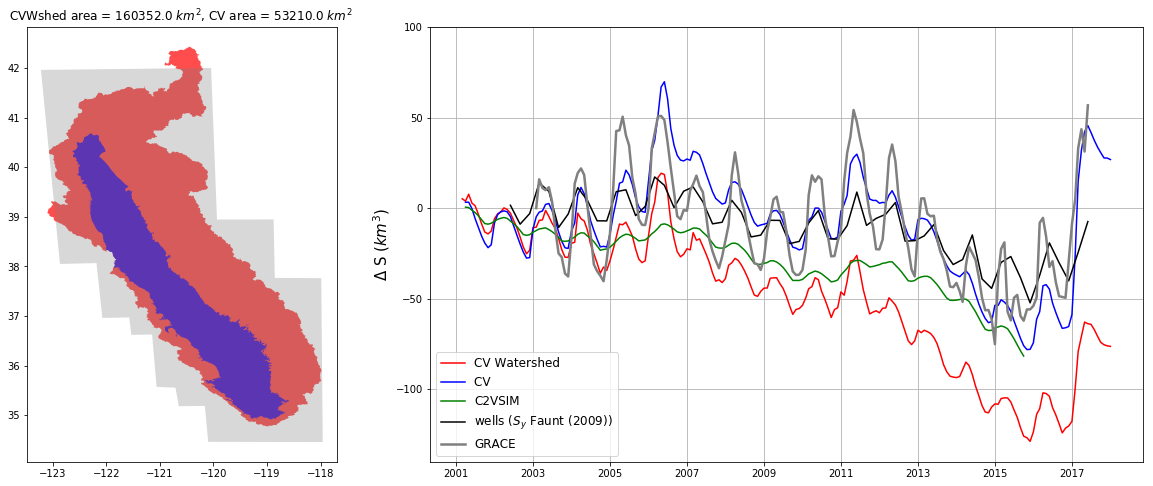

In [8]:
plt.figure(figsize=(20, 8))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "gray", alpha = 0.3, legend = True)
axes_1.set_title("CVWshed area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 0), round(cv_km3, 0)))

axes_4 = plt.subplot(G[0:2, 1:])

axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="blue", label = "CV ")
axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="green", label = "C2VSIM")
axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="gray", label = "GRACE", linewidth = 2.5)

axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend(prop={'size': 12}, loc = "lower left")
axes_4.set_ylim(-140, 100)

plt.grid(True)
G.update(wspace=0.3, hspace=0.3) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

In [9]:
# Do triple collocation on grace, wells, rs model

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [10]:
x = np.cumsum(cvdf.ds)
y = wells.ds_km3
z = grace.adj


In [11]:
y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

In [13]:
e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

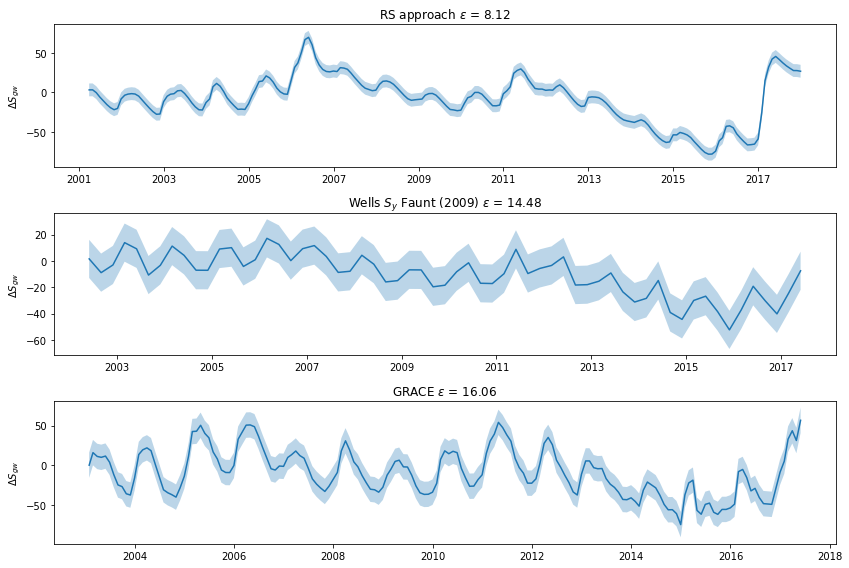

In [14]:
plt.figure(figsize = (12,8))

plt.subplot(3,1,1)
plt.plot(cvdf.index, x)
plt.fill_between(cvdf.index, x+e_x, x-e_x, alpha = 0.3)
plt.title("RS approach $\epsilon$ = {}".format(str(round(e_x, 2))))
plt.ylabel("$\Delta S_{gw}$")

plt.subplot(3,1,2)
plt.plot(wells.index, y)
plt.fill_between(wells.index, y+e_y, y-e_y, alpha = 0.3)
plt.title("Wells $S_y$ Faunt (2009) $\epsilon$ = {}".format(str(round(e_y,2)))) 
plt.ylabel("$\Delta S_{gw}$")

plt.subplot(3,1,3)
plt.plot(grace.index, z)
plt.fill_between(grace.index, z+e_z, z-e_z, alpha = 0.3)
plt.title("GRACE $\epsilon$ = {}".format(str(round(e_z,2))))
plt.ylabel("$\Delta S_{gw}$")

plt.tight_layout()

In [15]:
t1 = pd.merge(cvdf, wells, left_index=True, right_index=True, how = "outer")
t2 = pd.merge(t1, grace, left_index=True, right_index=True, how = "outer")

In [16]:
t2['cs'] = np.cumsum(t2.ds)
t2['ds_mean'] = np.nanmean(t2[['adj', 'ds_km3', "cs"]], axis = 1)

/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


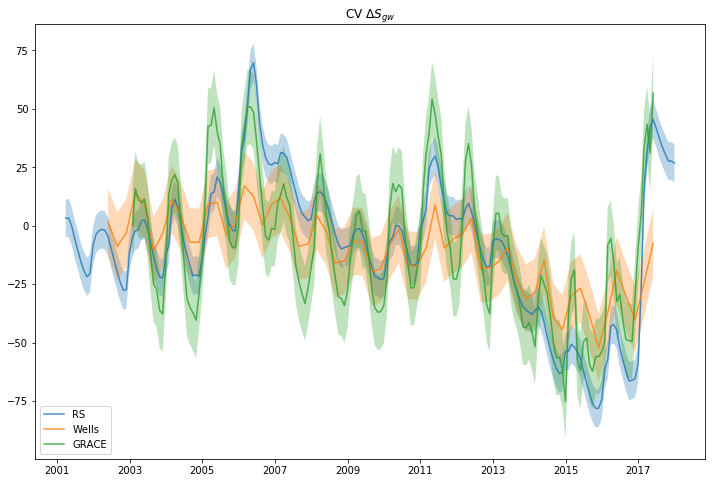

In [17]:
plt.figure(figsize = (12,8))
plt.title("CV $\Delta S_{gw}$")

plt.plot(cvdf.index, x, alpha = 0.8, label = "RS")
plt.fill_between(cvdf.index, x+e_x, x-e_x, alpha = 0.3)

plt.plot(wells.index, y, alpha = 0.8, label = "Wells")
plt.fill_between(wells.index, y+e_y, y-e_y, alpha = 0.3)

plt.plot(grace.index, z, alpha = 0.8, label = "GRACE")
plt.fill_between(grace.index, z+e_z, z-e_z, alpha = 0.3)
plt.legend(loc = "lower left")

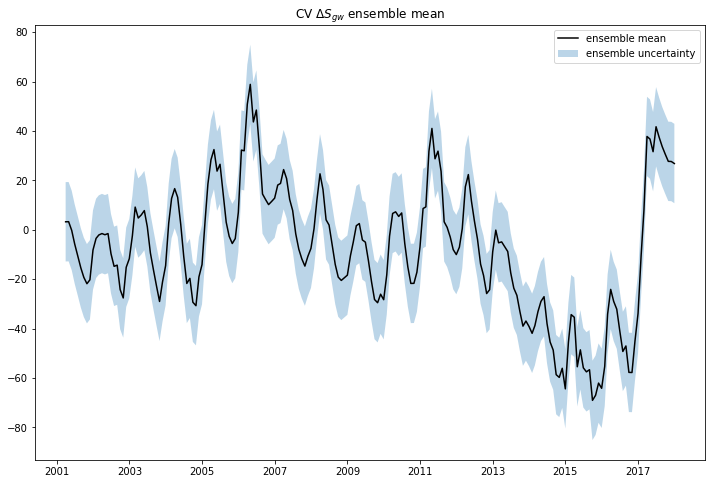

In [18]:
plt.figure(figsize = (12,8))
plt.title("CV $\Delta S_{gw}$ ensemble mean")

plt.plot(t2.ds_mean, color = "black", label = 'ensemble mean')
plt.fill_between(t2.index, t2.ds_mean + np.max([e_x,e_y,e_z]), t2.ds_mean - np.max([e_x,e_y,e_z]), alpha = 0.3, label = 'ensemble uncertainty')
plt.legend()

In [62]:
cvdf['ensmean'] = t2.ds_mean

In [82]:
table = cvdf.copy()

In [83]:
table.drop(['dt','ensmean','ds'], axis = 1, inplace = True)
table['s'] =cvdf.s.diff()

In [84]:
table.head()

,runoff,soil_moisture,prism,chirps,persiann,trmm,daymet,modis,gmet_eto,gmet_etr,fldas,terraclimate,p_mean,et_mean,q_in,q_out,res_s,s
Unnamed: 0,,,,,,,,,,,,,,,,,,
2001-02-28,2.458749,5.617042,5.235038,5.226746,6.747654,6.335718,6.021915,1.478157,2.506657,3.500802,1.452829,2.231485,5.913414,2.233986,0.910203,0.934155,1.360578,NaN
2001-03-31,3.564744,4.870329,2.491463,3.672229,3.513628,2.654442,2.852660,2.567967,5.077707,6.664522,2.653953,2.833132,3.036885,3.959456,1.073602,1.069754,1.511984,0.541821
2001-04-30,1.766841,4.025034,1.878540,2.105821,2.805618,2.463260,2.158581,1.941402,6.177018,8.027978,2.557924,3.043004,2.282364,4.349465,1.069572,1.397268,1.690033,-0.232405
2001-05-31,2.075971,2.663451,0.011473,0.331417,0.138700,0.047406,0.012995,2.227203,11.745110,16.009652,2.639233,1.425336,0.108398,6.809307,1.344885,1.550421,1.738200,-1.468966
2001-06-30,0.141380,1.913041,0.179280,0.236480,0.338828,0.215947,0.229939,1.028790,11.815112,16.120875,1.591223,0.944203,0.240095,6.300041,1.525715,2.113784,1.493013,-1.264224


In [85]:
# A function that generates the annomaly time series. 
# The function is similar to climate based data filling in notebook 2 (QC) step 3/5. 

def func(table):
    yearInt = min(table.index.year)
    yearMax = max(table.index.year)+1
    years = np.arange(yearInt,yearMax, 1)
    lenYear = np.count_nonzero(years)
    nameVar = table.columns
    numCol = len(nameVar)
    xmax = 367 # days in a year
    
    TableFinal = copy.deepcopy(table)
    for j in range(0,numCol): # variable being processed
        AnnualTable = np.ones([(yearMax-yearInt),xmax])*np.nan
        y4 = table[nameVar[j]].copy(deep=True)
        VarName = table.columns[j]

        for year in years: # years
            d = y4[y4.index.year==year].copy(deep=True)
            AnnualTable[year-yearInt,0] = year
            AnnualTable[year-yearInt,(xmax - (d.shape[0]) ):(xmax)] = d.values # If the year does not start at Jan 1
            # 365 starts at 1 while 366 start at 2
        
        
        AnnualMean = (np.nanmean(AnnualTable,axis=0))
        AnnualAnomaly = AnnualTable - AnnualMean   # For a single variable
        y5 = y4.copy(deep=True)*np.nan
        
        for year in years:
            d = y5[y5.index.year==year].copy(deep=True)
            ddim = d.shape[0]
            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(xmax - (d.shape[0]) ):(xmax)]
        #print(VarName,TableFinal.shape)
        TableFinal.loc[y5.index,VarName] = y5.loc[y5.index]
    
    return TableFinal

In [86]:
def moving_avg_anom(table, window):
    AnoTable = pd.DataFrame()
    for k in table.keys():
        m = table[k].rolling(table[k], window, min_periods=None, freq=None, center=True)
        AnoTable[k] = (table[k] - m) / (np.max(table[k]) - np.min(table[k]))
    AnoTable = AnoTable.dropna()
    return AnoTable

###  Step 0 Load Data & Select Periods of Record

In [87]:
table.keys()

Index(['runoff', 'soil_moisture', 'prism', 'chirps', 'persiann', 'trmm',
       'daymet', 'modis', 'gmet_eto', 'gmet_etr', 'fldas', 'terraclimate',
       'p_mean', 'et_mean', 'q_in', 'q_out', 'res_s', 's'],
      dtype='object')

###  Step 1a DAY OF YEAR Anomaly time series to account for seasonality 

/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/anaconda3/envs/BIDS/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/

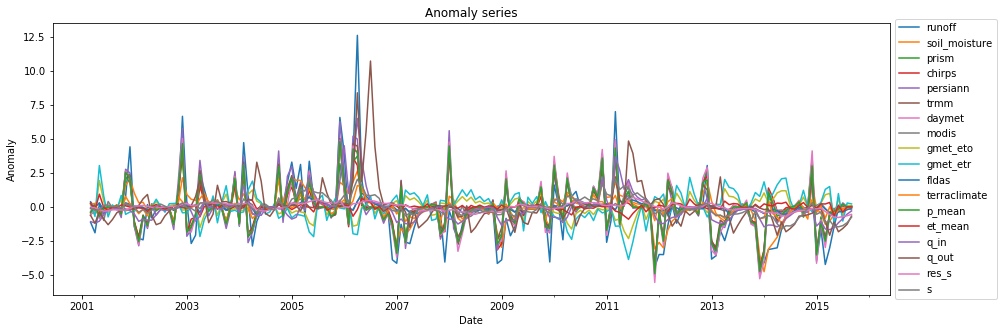

In [88]:
AnoTable_all = func(table=table)
AnoTable_all.loc[AnoTable_all.index.year==2015, AnoTable_all.columns[0]]
AnoTable_all = AnoTable_all.dropna()
AnoTable_all.plot(figsize=[15,5])
plt.title('Anomaly series')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

###  Step 1b MOVING AVERAGE Anomaly time series to account for seasonality

In [27]:
AnoTable_all = moving_avg_anom(table, 21)
AnoTable_all.plot(figsize=[15,5])
plt.title('Anomaly series')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

TypeError: rolling() got multiple values for argument 'min_periods'

### Step 2 Define input parameters for the TE function

In [89]:
Table = copy.deepcopy(AnoTable_all.loc[AnoTable_all.index, AnoTable_all.columns])
numVr =  Table.shape[1]
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.arange(1, numVr)
SinN = np.array([-1])
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))

### Step 3 Apply the TE function

In [126]:
%%time
# step 2/3
# Applying TE on the moving average data
sf = [-1, 0, -1]
numShuffles = 500
maxLag = 10
ncore = 4
Imat, Icritmat, Tfirstmat,  Tbiggestmat, Tcube_store,  Tcritcube_store = \
                                        TEpython_Parallel.RunNewTE2VarsPar(DataMatrix = DataM,
                                                                           ncores=ncore,
                                                                           LabelCell=LabelC, 
                                                                           shift=sf,
                                                                           SinkNodes=SinN,
                                                                           SourceNodes=SourN,
                                                                           maxLag=maxLag,
                                                                           minSamples=10,
                                                                           sigLevel=0.1,
                                                                           numBins=[5,5,5],
                                                                           numShuffles=numShuffles)

  0%|          | 0/17 [00:00<?, ?it/s]

sink node =  0
Source node  0 runoff :=> Sink node  -1 s


  6%|▌         | 1/17 [00:02<00:45,  2.85s/it]

Source node  1 soil_moisture :=> Sink node  -1 s


 12%|█▏        | 2/17 [00:05<00:42,  2.84s/it]

Source node  2 prism :=> Sink node  -1 s


 18%|█▊        | 3/17 [00:08<00:39,  2.86s/it]

Source node  3 chirps :=> Sink node  -1 s


 24%|██▎       | 4/17 [00:11<00:37,  2.91s/it]

Source node  4 persiann :=> Sink node  -1 s


 29%|██▉       | 5/17 [00:14<00:35,  2.93s/it]

Source node  5 trmm :=> Sink node  -1 s


 35%|███▌      | 6/17 [00:17<00:32,  2.98s/it]

Source node  6 daymet :=> Sink node  -1 s


 41%|████      | 7/17 [00:20<00:30,  3.01s/it]

Source node  7 modis :=> Sink node  -1 s


 47%|████▋     | 8/17 [00:23<00:26,  2.93s/it]

Source node  8 gmet_eto :=> Sink node  -1 s


 53%|█████▎    | 9/17 [00:26<00:23,  2.90s/it]

Source node  9 gmet_etr :=> Sink node  -1 s


 59%|█████▉    | 10/17 [00:29<00:19,  2.83s/it]

Source node  10 fldas :=> Sink node  -1 s


 65%|██████▍   | 11/17 [00:31<00:17,  2.84s/it]

Source node  11 terraclimate :=> Sink node  -1 s


 71%|███████   | 12/17 [00:34<00:14,  2.82s/it]

Source node  12 p_mean :=> Sink node  -1 s


 76%|███████▋  | 13/17 [00:37<00:11,  2.81s/it]

Source node  13 et_mean :=> Sink node  -1 s


 82%|████████▏ | 14/17 [00:40<00:08,  2.85s/it]

Source node  14 q_in :=> Sink node  -1 s


 88%|████████▊ | 15/17 [00:43<00:05,  2.89s/it]

Source node  15 q_out :=> Sink node  -1 s


 94%|█████████▍| 16/17 [00:46<00:02,  2.92s/it]

Source node  16 res_s :=> Sink node  -1 s


100%|██████████| 17/17 [00:49<00:00,  2.97s/it]

CPU times: user 5.31 s, sys: 391 ms, total: 5.7 s
Wall time: 49.4 s


### Step 4 Postprocessing results

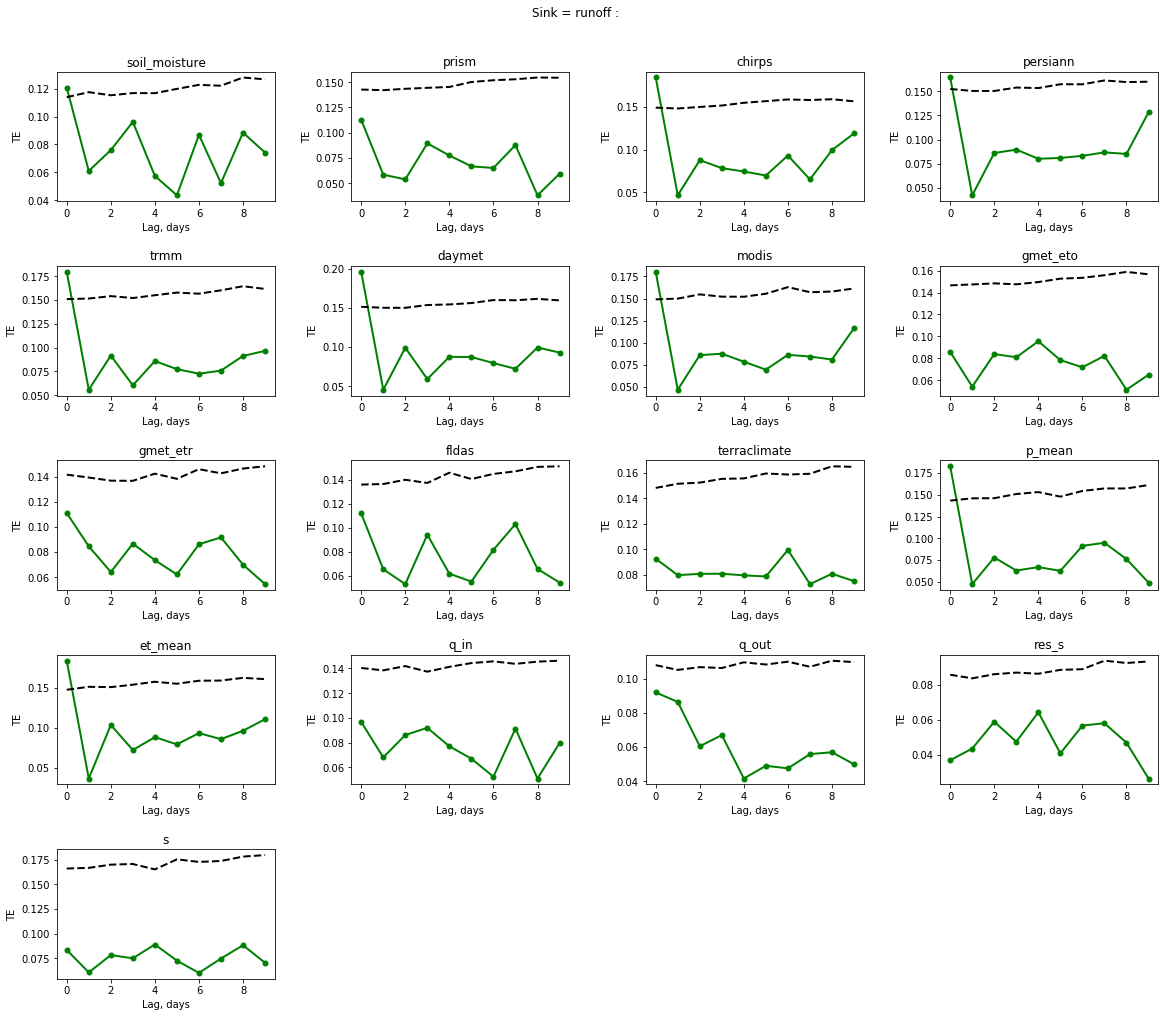

In [127]:
# plotting results of TE one variable at a time

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    
    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    plt.suptitle('Sink = %s :'%(LabelC[1]))
    plt.title((LabelC[i+2]))

    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

Text(0.5,0,'TE at Lag (mons)')

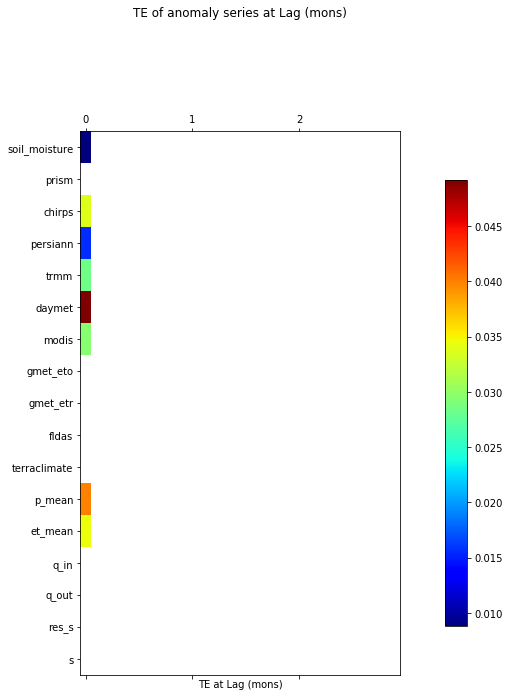

In [125]:
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic < 0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[2:]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,10)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='jet',aspect=3)
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,10)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(np.arange(maxLag))
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (mons)',y=1.2)
plt.xlabel('TE at Lag (mons)')
#plt.grid()

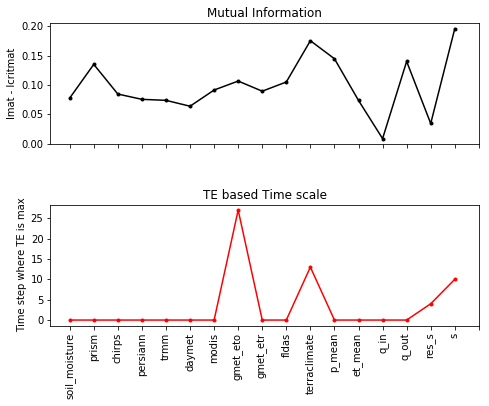

In [123]:
# Plotting Critical timescale and Mutual information. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')

plt.subplot(2,1,2)

plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)